In [17]:
import numpy as np
import joblib
import xgboost as xgb

from acpi import utils

In [18]:
class XGBoostACPIWrapper:
    """ACPI wrapper for an XGBoost model."""

    def __init__(self, model):
        self.model = model

    def predict(self, X):
        """Predict using the XGBoost model, handling DMatrix conversion."""
        dmatrix = xgb.DMatrix(X)
        return self.model.predict(dmatrix)

In [19]:
# load the acpi model
acpi_model = joblib.load("./models/acpi_xgboost_model_1.pkl")

C:\Users\joobzm\Desktop\TDK\ACPI\.venv11\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\joobzm\Desktop\TDK\ACPI\.venv11\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [20]:
DATA_TRAIN_PATH = "../data/train.csv"
DATA_TEST_PATH = "../data/test.csv"
target_col = "count"
context_length = 24

In [21]:
train_df = utils.read_bike_data(DATA_TRAIN_PATH)
test_df = utils.read_bike_data(DATA_TEST_PATH)
feature_cols = [c for c in train_df.columns if c != target_col and c in test_df.columns]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[feature_cols].values.astype(np.float32))
train_target = train_df[target_col].values.astype(np.float32)

# Windowed supervised data
X_all, y_all = utils.build_lag_supervised(train_features, train_target, context_length)

# Time-ordered splits: model train / holdout
train_ratio = 0.8
n_train = int(len(X_all) * train_ratio)
X_test_hold, y_test_hold = X_all[n_train:], y_all[n_train:]

cal_size = 0.5
n_cal = int(len(X_test_hold) * cal_size)
X_test_acpi, y_test_acpi = X_test_hold[n_cal:], y_test_hold[n_cal:]

# Point predictions from the wrapped base model inside ACPI
predictions = acpi_model.model_cali.predict(X_test_acpi)

In [22]:
y_lower, y_upper =  acpi_model.predict_pi(X_test_acpi, method='qrf')

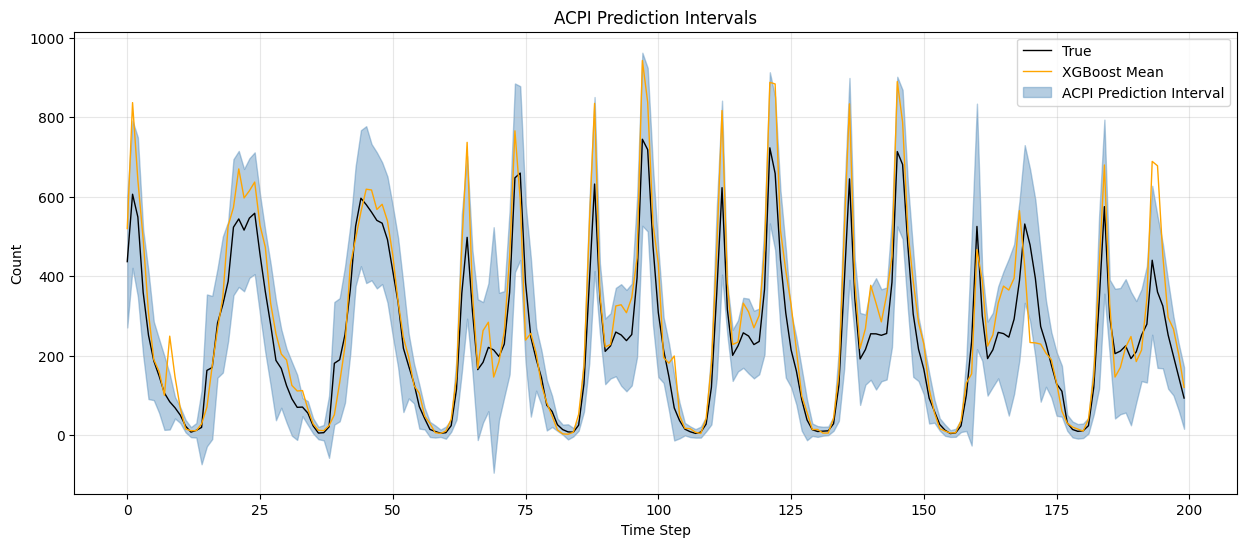

(<Figure size 1500x600 with 1 Axes>,
 <Axes: title={'center': 'ACPI Prediction Intervals'}, xlabel='Time Step', ylabel='Count'>)

In [23]:
utils.plot_acpi_predictions(predictions, y_test_acpi, y_lower, y_upper)

In [24]:
# Evaluate the model
mse = np.mean((predictions - y_test_acpi) ** 2)
mae = np.mean(np.abs(predictions - y_test_acpi))
rmse = np.sqrt(mse)
mape = np.mean(np.abs((predictions - y_test_acpi) / y_test_acpi
                    )) * 100  # Mean Absolute Percentage Error
r2 = 1 - (np.sum((y_test_acpi - predictions) ** 2) / np.sum((y_test_acpi - np.mean(y_test_acpi)) ** 2))
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 4562.06
Mean Absolute Error: 44.85
Root Mean Squared Error: 67.54
Mean Absolute Percentage Error: 37.47%
R^2 Score: 0.88


In [25]:
# get coverage
coverage = utils.compute_coverage(y_test_acpi, y_lower, y_upper)
print(f"Coverage: {coverage:.2f}")


Coverage: 0.94


# greedy, gradient‑free stochastic local search (aka random shooting)

In [44]:
# Python
from typing import Optional, Tuple, Dict, Any, Iterable
import numpy as np
from alibi.api.interfaces import Explainer, Explanation

class CoverageCounterfactualGenerator(Explainer):
    """
    Black-box, coverage-oriented counterfactual generator (Alibi-style).
    Objective: reduce empirical coverage below `target_coverage` by minimally perturbing inputs.

    Assumptions:
    - `acpi_model.predict_pi(X)` returns (y_lower, y_upper) aligned with provided `y`.
    - Operates directly in the feature space used to query `acpi_model` (e.g., lagged, scaled).
    """

    def __init__(
        self,
        acpi_model: Any,
        mutable_idx: Optional[Iterable[int]] = None,
        feature_bounds: Optional[Tuple[np.ndarray, np.ndarray]] = None,
        step_scale: float = 0.1,
        per_sample_budget: int = 64,
        max_global_iters: int = 10,
        random_state: int = 0
    ):
        super().__init__(meta={
            "name": "CoverageCounterfactualGenerator",
            "type": "blackbox-coverage-cf",
            "version": "1.0.0"
        })
        self.acpi_model = acpi_model
        self.mutable_idx = None if mutable_idx is None else np.array(list(mutable_idx), dtype=int)
        self.feature_bounds = feature_bounds  # (lb, ub) in model input space or None
        self.step_scale = float(step_scale)
        self.per_sample_budget = int(per_sample_budget)
        self.max_global_iters = int(max_global_iters)
        self.rng = np.random.RandomState(random_state)

    @staticmethod
    def _coverage(y: np.ndarray, y_lo: np.ndarray, y_hi: np.ndarray) -> Tuple[float, np.ndarray]:
        inside = (y >= y_lo) & (y <= y_hi)
        return float(inside.mean()), inside

    @staticmethod
    def _margin(y: np.ndarray, y_lo: np.ndarray, y_hi: np.ndarray) -> np.ndarray:
        # Positive if covered; negative if outside (distance to nearest bound, signed outward)
        return np.minimum(y - y_lo, y_hi - y)

    def _bounds(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        if self.feature_bounds is not None:
            lb, ub = self.feature_bounds
            return lb.astype(X.dtype), ub.astype(X.dtype)
        # Fallback: empirical bounds from X (per-feature). Expand slightly to allow small moves.
        lb = np.percentile(X, 1, axis=0)
        ub = np.percentile(X, 99, axis=0)
        eps = 1e-6
        span = np.maximum(ub - lb, eps)
        return (lb - 0.05 * span).astype(X.dtype), (ub + 0.05 * span).astype(X.dtype)

    def _clip(self, X: np.ndarray, lb: np.ndarray, ub: np.ndarray) -> np.ndarray:
        return np.clip(X, lb, ub)

    def _propose(self, x: np.ndarray) -> np.ndarray:
        d = x.shape[-1]
        idx = self.mutable_idx if self.mutable_idx is not None else np.arange(d)
        delta = np.zeros_like(x)
        # Gaussian step on mutable dims
        delta[idx] = self.rng.normal(loc=0.0, scale=self.step_scale, size=len(idx))
        return x + delta

    def explain(
        self,
        X: np.ndarray,
        y: np.ndarray,
        target_coverage: float,
        instance_order: str = "easiest-first"
    ) -> Explanation:
        """
        Generate counterfactuals for rows in X to push empirical coverage below target.

        Params:
        - X: [n, d] inputs in the same model space as `acpi_model`.
        - y: [n] ground truth targets aligned with X.
        - target_coverage: desired upper bound for empirical coverage (0..1).
        - instance_order: 'easiest-first' uses smallest positive margin first.

        Returns:
        - Explanation with fields: original, cf, changed, coverage_before, coverage_after, target_coverage, mask, deltas.
        """
        X = np.array(X, dtype=np.float32, copy=True)
        y = np.array(y, dtype=np.float32, copy=False).reshape(-1)
        n, d = X.shape

        lb, ub = self._bounds(X)
        X_cf = X.copy()

        # Initial coverage
        y_lo, y_hi = self.acpi_model.predict_pi(X_cf)
        cov_before, inside = self._coverage(y, y_lo, y_hi)
        margins = self._margin(y, y_lo, y_hi)

        # Order instances to try flipping coverage
        idx_all = np.arange(n)
        if instance_order == "easiest-first":
            # Only covered points are candidates; smaller margin means easier to push out
            order = idx_all[inside]
            order = order[np.argsort(margins[inside])]
        else:
            order = idx_all

        # Global loop: iterate passes until target reached or budget spent
        changed_mask = np.zeros(n, dtype=bool)
        for _ in range(self.max_global_iters):
            # Early stop if already below target
            y_lo, y_hi = self.acpi_model.predict_pi(X_cf)
            cov_now, inside = self._coverage(y, y_lo, y_hi)
            if cov_now <= target_coverage:
                break

            # Try to flip covered points
            for i in order:
                # Skip if already uncovered or coverage already under target
                y_lo_i, y_hi_i = y_lo[i], y_hi[i]
                if not (y[i] >= y_lo_i and y[i] <= y_hi_i):
                    continue

                x0 = X_cf[i].copy()
                best_x = x0
                best_margin = margins[i]  # positive if covered
                improved = False

                for _step in range(self.per_sample_budget):
                    x_prop = self._propose(x0)
                    x_prop = self._clip(x_prop, lb, ub)

                    lo_p, hi_p = self.acpi_model.predict_pi(x_prop[None, :])
                    lo_p, hi_p = lo_p[0], hi_p[0]
                    # If uncovered, accept immediately
                    if not (y[i] >= lo_p and y[i] <= hi_p):
                        best_x = x_prop
                        improved = True
                        break

                    # Else, prefer smaller positive margin
                    m = min(y[i] - lo_p, hi_p - y[i])
                    if m < best_margin:
                        best_margin = m
                        best_x = x_prop

                if improved or best_margin < margins[i]:
                    X_cf[i] = best_x
                    changed_mask[i] = True

                # Recompute running coverage to enable early stop
                y_lo, y_hi = self.acpi_model.predict_pi(X_cf)
                cov_now, inside = self._coverage(y, y_lo, y_hi)
                margins = self._margin(y, y_lo, y_hi)
                if cov_now <= target_coverage:
                    break

        # Final metrics
        y_lo_f, y_hi_f = self.acpi_model.predict_pi(X_cf)
        cov_after, _ = self._coverage(y, y_lo_f, y_hi_f)

        exp = Explanation(
            meta={
                **self.meta,
                "params": {
                    "target_coverage": float(target_coverage),
                    "step_scale": self.step_scale,
                    "per_sample_budget": self.per_sample_budget,
                    "max_global_iters": self.max_global_iters
                }
            },
            data={
                "original": X,
                "cf": X_cf,
                "deltas": X_cf - X,
                "changed": changed_mask,
                "coverage_before": float(cov_before),
                "coverage_after": float(cov_after),
                "target_coverage": float(target_coverage),
                "y_true": y,
                "y_lower_before": y_lo,
                "y_upper_before": y_hi,
                "y_lower_after": y_lo_f,
                "y_upper_after": y_hi_f
            }
        )
        return exp

In [45]:
# Python
# Example: drive coverage on the holdout slice below 75%
target_cov = 0.75

# Optional: restrict which features can change (e.g., keep lag targets fixed)
# mutable_idx = np.setdiff1d(np.arange(X_test_acpi.shape[1]), fixed_idx)
mutable_idx = None  # allow all features by default

cf_gen = CoverageCounterfactualGenerator(
    acpi_model=acpi_model,
    mutable_idx=mutable_idx,
    feature_bounds=None,      # or (lower_bounds, upper_bounds) in model input space
    step_scale=0.05,
    per_sample_budget=64,
    max_global_iters=5,
    random_state=0
)

exp = cf_gen.explain(X_test_acpi, y_test_acpi, target_coverage=target_cov)

print(f"Coverage before: {exp.data['coverage_before']:.3f}")
print(f"Coverage after:  {exp.data['coverage_after']:.3f} (target {exp.data['target_coverage']:.3f})")

# Counterfactual inputs and deltas
X_cf = exp.data["cf"]
deltas = exp.data["deltas"]
changed = exp.data["changed"]

# Optional: visualize a few changed rows
changed_idx = np.where(changed)[0][:5]
for i in changed_idx:
    print(f"Row {i}: any change={changed[i]}, delta_norm={np.linalg.norm(deltas[i]):.3f}")

Coverage before: 0.944
Coverage after:  0.750 (target 0.750)
Row 3: any change=True, delta_norm=0.785
Row 10: any change=True, delta_norm=0.823
Row 11: any change=True, delta_norm=0.811
Row 12: any change=True, delta_norm=0.805
Row 13: any change=True, delta_norm=0.850
